In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch, torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from custom_dataset import CustomDataset
from trainer import train_fn, collate_fn

In [2]:
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomSizedBBoxSafeCrop(height=300, width=300, p=0.5),
        A.HueSaturationValue(hue_shift_limit=(-20/180, 20/180), 
                             sat_shift_limit=(-30/255, 30/255), 
                             val_shift_limit=(-20/255, 20/255), p=0.5),
        A.Resize(1024, 1024), 
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [3]:
annotation = '../dataset/train.json' 
data_dir = '../dataset' 
train_dataset = CustomDataset(annotation, data_dir, get_train_transform(), mosaic=True) 

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


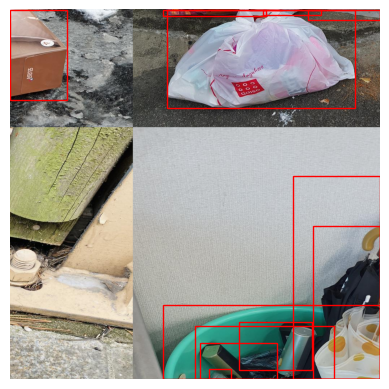

In [4]:
image5, target5, index5 = train_dataset[5]
image5 = image5.permute(1,2,0)
fig, ax = plt.subplots(1)
for i, label in enumerate(target5['labels']):

    x_min, y_min, x_max, y_max = target5['boxes'][i]
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
ax.imshow(image5)

In [5]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 11 

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 12 # change num_epochs if you want to change  

train_fn(num_epochs, train_data_loader, optimizer, model, device)

cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 306/306 [08:19<00:00,  1.63s/it]


Epoch #1 loss: 1.3325457000264935


100%|██████████| 306/306 [08:16<00:00,  1.62s/it]


Epoch #2 loss: 1.1199698837753993


100%|██████████| 306/306 [08:24<00:00,  1.65s/it]


Epoch #3 loss: 1.065621264230192


100%|██████████| 306/306 [08:15<00:00,  1.62s/it]


Epoch #4 loss: 1.0401910623304205


 20%|██        | 62/306 [01:42<06:45,  1.66s/it]


KeyboardInterrupt: 